# Spam classification on the spambase dataset
The purpose of this model is to create a classifier for marking e-mails as spam. The data is sourced from the Spambase dataset available on many machine learning dataset platforms (ie. https://archive.ics.uci.edu/ml/datasets/spambase). The class attribute is whether the e-mail was spam (1) or not (0). Other attributes used for predictions are the frequencies of certain words or characters.

In [113]:
import numpy as np
import pandas as pd

random_seed = 5042021
np.random.seed(random_seed)

all_data = pd.read_csv('dataset_44_spambase.csv')



Check the columns of the dataset.

In [114]:
all_data[:2]

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_%3B,char_freq_%28,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.0,0.00,...,0.0,0.000,0.0,0.778,0.00,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.0,0.94,...,0.0,0.132,0.0,0.372,0.18,0.048,5.114,101,1028,1


In [115]:
len(all_data.index)

4601

In [116]:
len(all_data[all_data["class"]==1])

1813

In [117]:
len(all_data[all_data["class"]==0])

2788

## Data preprocessing

First, we check whether we have any null values in our dataset.

In [118]:
all_data.isnull().sum()

word_freq_make                0
word_freq_address             0
word_freq_all                 0
word_freq_3d                  0
word_freq_our                 0
word_freq_over                0
word_freq_remove              0
word_freq_internet            0
word_freq_order               0
word_freq_mail                0
word_freq_receive             0
word_freq_will                0
word_freq_people              0
word_freq_report              0
word_freq_addresses           0
word_freq_free                0
word_freq_business            0
word_freq_email               0
word_freq_you                 0
word_freq_credit              0
word_freq_your                0
word_freq_font                0
word_freq_000                 0
word_freq_money               0
word_freq_hp                  0
word_freq_hpl                 0
word_freq_george              0
word_freq_650                 0
word_freq_lab                 0
word_freq_labs                0
word_freq_telnet              0
word_fre

No null values are present. Furthermore, the dataset gives no indication that 0 values should be treated as missing (as the 

### Derived columns

In this section we will derive our new columns. Most columns are represented as frequencies, until the last three columns, which are an average, the longest occurence and the total number of capital letters. Spam is not always long, so a metric involving a "total" could skew the classifier to longer or shorter messages. Another derived column is the ratio of common words (from word_freq columns) to the mean of common words. The rationale behind this is to discover whether the list of common words truly helps predict spam or not. Even though the column is already in percentages, it is still calculated as a ratio to its mean.

In [119]:
all_data["capital_run_length_ratio"] = (
    all_data["capital_run_length_longest"] / all_data["capital_run_length_total"]
)

all_data["capital_run_length_ratio"] = (
    all_data["capital_run_length_longest"] / all_data["capital_run_length_total"]
)

all_data["total_word_frequency_common"] = (
    all_data["word_freq_make"] + all_data["word_freq_address"] + all_data["word_freq_all"] + all_data["word_freq_3d"] + all_data["word_freq_our"] + all_data["word_freq_over"] + all_data["word_freq_remove"] + all_data["word_freq_internet"] + all_data["word_freq_order"] + all_data["word_freq_mail"] + all_data["word_freq_receive"] + all_data["word_freq_will"] + all_data["word_freq_people"] + all_data["word_freq_report"] + all_data["word_freq_addresses"] + all_data["word_freq_free"] + all_data["word_freq_business"] + all_data["word_freq_email"] + all_data["word_freq_you"] + all_data["word_freq_credit"] + all_data["word_freq_your"] + all_data["word_freq_font"] + all_data["word_freq_000"] + all_data["word_freq_money"] + all_data["word_freq_hp"] + all_data["word_freq_hpl"] + all_data["word_freq_george"] + all_data["word_freq_650"] + all_data["word_freq_lab"] + all_data["word_freq_labs"] + all_data["word_freq_telnet"] + all_data["word_freq_857"] + all_data["word_freq_data"] + all_data["word_freq_415"] + all_data["word_freq_85"] + all_data["word_freq_technology"] + all_data["word_freq_1999"] + all_data["word_freq_parts"] + all_data["word_freq_pm"] + all_data["word_freq_direct"] + all_data["word_freq_cs"] + all_data["word_freq_meeting"] + all_data["word_freq_original"] + all_data["word_freq_project"] + all_data["word_freq_re"] + all_data["word_freq_edu"] + all_data["word_freq_table"] + all_data["word_freq_conference"]
)

all_data["word_frequency_common_mean_ratio"] = all_data["total_word_frequency_common"] / all_data["total_word_frequency_common"].mean()

all_data = all_data.drop(columns=['total_word_frequency_common', 'capital_run_length_longest', 'capital_run_length_total', 'capital_run_length_average'])

all_data

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_conference,char_freq_%3B,char_freq_%28,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23,class,capital_run_length_ratio,word_frequency_common_mean_ratio
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.0,0.000,0.000,0.0,0.778,0.000,0.000,1,0.219424,0.720346
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.0,0.000,0.132,0.0,0.372,0.180,0.048,1,0.098249,1.187396
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.0,0.010,0.143,0.0,0.276,0.184,0.010,1,0.214697,1.170295
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.000,0.137,0.0,0.137,0.000,0.000,1,0.209424,0.773784
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.000,0.135,0.0,0.135,0.000,0.000,1,0.209424,0.773784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,0.00,...,0.0,0.000,0.232,0.0,0.000,0.000,0.000,0,0.034091,0.499112
4597,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.000,0.000,0.0,0.353,0.000,0.000,0,0.285714,1.068763
4598,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.102,0.718,0.0,0.000,0.000,0.000,0,0.050847,0.705384
4599,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.0,0.000,0.057,0.0,0.000,0.000,0.000,0,0.064103,0.479875


### Subsetting
Next we remove cells where the word frequency for George was above or equal to one in an attempt to make our spam filter more generic, performing subsetting.

In [120]:
#all_data[(all_data["word_freq_george"] > 0) & (all_data["class"] == 1)]

all_data = all_data[all_data["word_freq_george"] == 0]

## Train-test split

First off, we are using a train test split of size 0.3.

In [121]:
from sklearn.model_selection import train_test_split

predictors = all_data.columns.values.tolist()
predictors.remove('class')

X = all_data[predictors].values
y = all_data['class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)

## K-NN model

In [122]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

parametergrid= {
    "n_neighbors":(2, 5, 10)
}

knn = KNeighborsClassifier()

clf = GridSearchCV(knn, parametergrid)
clf.fit(X_train, y_train)


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': (2, 5, 10)})

In [123]:
def confusion_matrix_values(cm):
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])

y_pred = clf.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_lr = confusion_matrix(y_test, y_pred)

confusion_matrix_values(cm_lr)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

True positive =  539
False positive =  70
False negative =  57
True negative =  481


0.8892763731473409

On first look, it is noticeable that even the best estimated K-NN model could have a better (lower) false positive rate despite its overall good accuracy. For this reason, as well as the slowness of K-NN and the lack of class weights, we proceed to our second model.

## Decision tree model

We train a decision tree classifier, mostly because it is farily simple to implement a decision tree classifier in any e-mail software one might use, and the algorithms for making "personalized" decision trees for any given user are not too expensive to run on any hardware either. We also adjust class weights to heavily discourage false positives (marking good e-mails as spam is very undesirable and requires the user to check their spam folder constantly, frustrating the user).

In [124]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

parametergrid= {
    "criterion" : ("gini", "entropy"),
    "min_samples_split":(10, 20, 30),
    "max_depth":(1,2,3,4),
}

dectree = DecisionTreeClassifier(random_state=random_seed, class_weight={0:8.0, 1:1.0})

clf = GridSearchCV(dectree, parametergrid)
clf.fit(X_train, y_train)

clf.best_score_ 

0.8242472610171865

In [125]:
print(clf.best_estimator_)


DecisionTreeClassifier(class_weight={0: 8.0, 1: 1.0}, max_depth=4,
                       min_samples_split=10, random_state=5042021)


In [126]:

y_pred = clf.predict(X_test)

cm_lr = confusion_matrix(y_test, y_pred)
confusion_matrix_values(cm_lr)
accuracy_score(y_test, y_pred)


True positive =  598
False positive =  11
False negative =  195
True negative =  343


0.8204010462074979

In [127]:
from sklearn import tree
from matplotlib import pyplot as plt

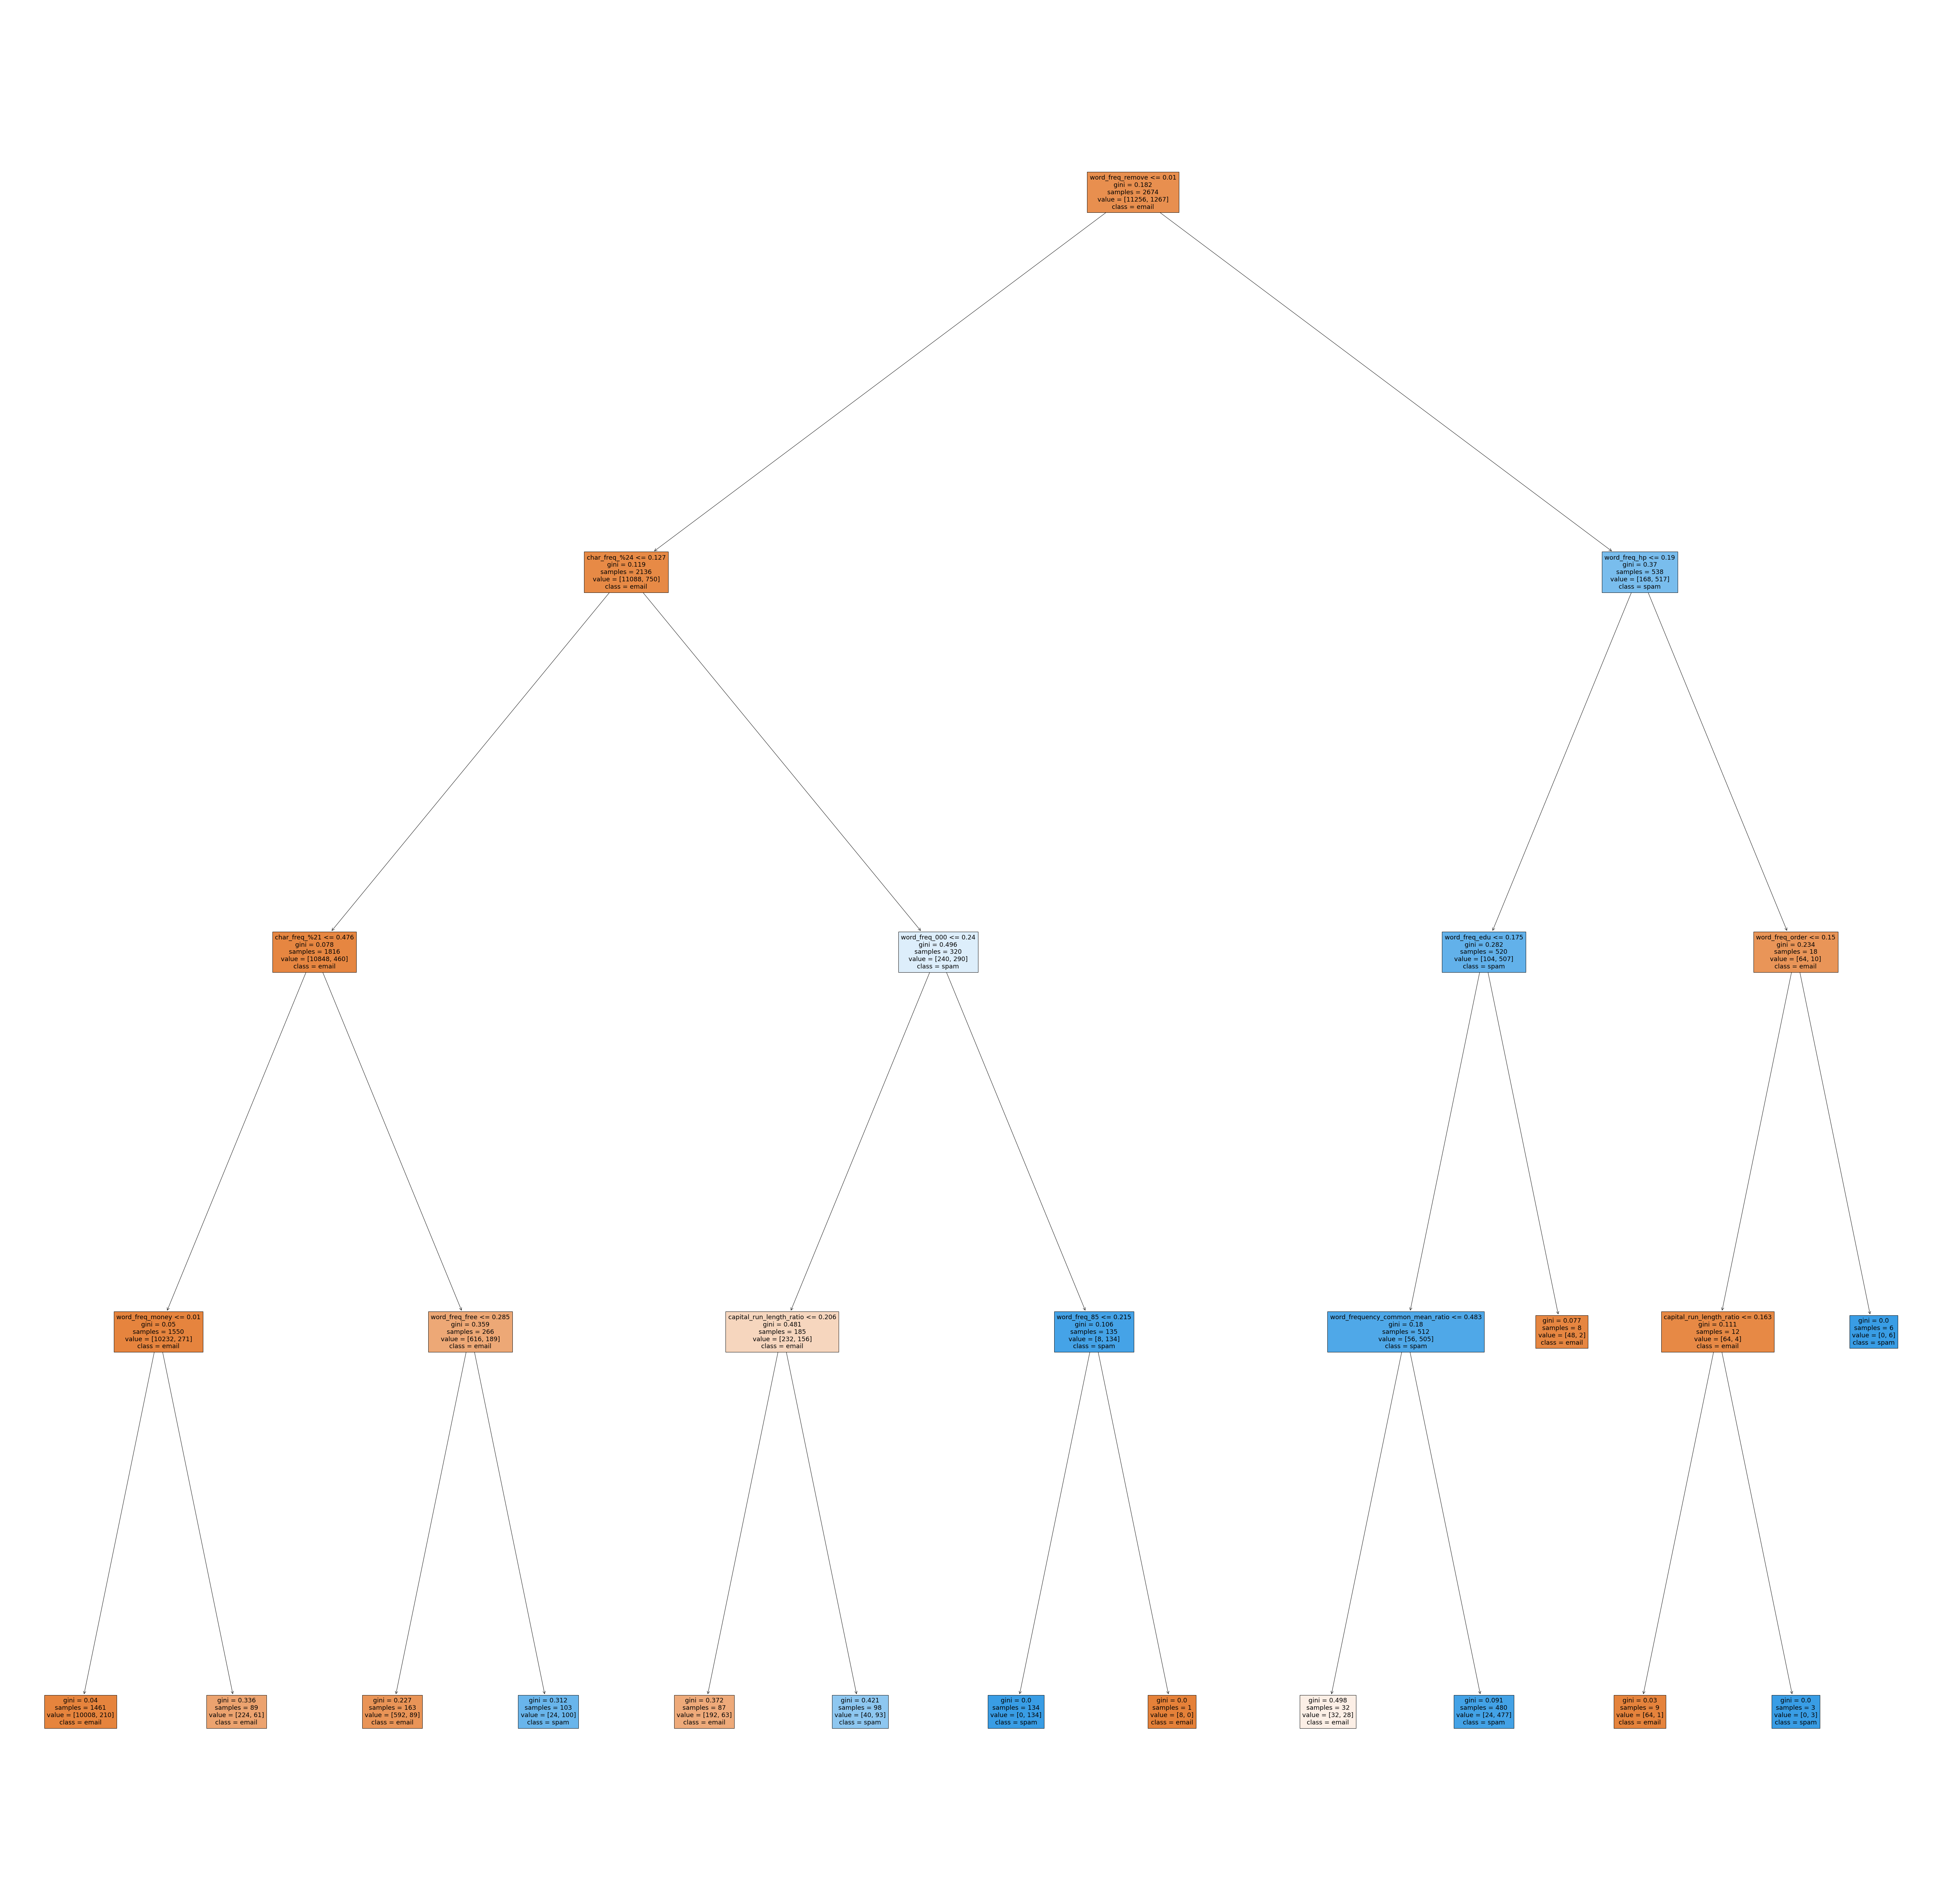

In [128]:
fig = plt.figure(figsize=(100,100))
_ = tree.plot_tree(clf.best_estimator_, 
                   feature_names=predictors,  
                   class_names=["email", "spam"],
                   filled=True)


On first look we can see that some leaf nodes are redundant and could be pruned using a post-pruning algorithm (the two left-most leaves). Overall the decision tree looks relatively simple.

In [129]:
fig.savefig("decistion_tree2.png")

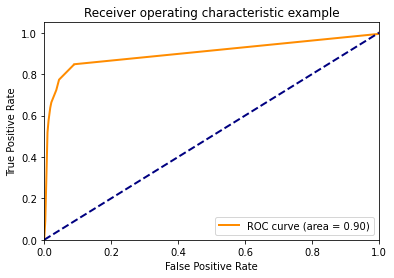

In [130]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

y_test_probs = clf.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
roc_auc = roc_auc_score(y_test, y_test_probs)


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

The AUC (0.9) is very good, indicating that the chance of the model differentiating between a positive and a negative class is 90 %.